# MMCOT

In [1]:
import networkx as nx
import argparse
import os
import sys
import numpy as np
import json
import torch
import torchvision
from PIL import Image
import gc
sys.path.append('/root/autodl-tmp/GroundedSAM_src/Grounded-Segment-Anything')
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

In [2]:
import pickle
def save_graph(graph, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(graph, f)

def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            # T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold,device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        scores.append(logit.max().item())

    return boxes_filt, torch.Tensor(scores), pred_phrases

In [3]:
import mimetypes
import os
from io import BytesIO
from typing import Union
import cv2
import requests
import torch
import transformers
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from tqdm import tqdm
import sys

sys.path.append("/root/autodl-tmp/Otter/Otter/src/otter_ai")
os.chdir('/root/autodl-tmp/Otter/Otter/src/otter_ai')
sys.path.append("..")
from models.otter.modeling_otter import OtterForConditionalGeneration


# Disable warnings
requests.packages.urllib3.disable_warnings()

# ------------------- Utility Functions -------------------


def get_content_type(file_path):
    content_type, _ = mimetypes.guess_type(file_path)
    return content_type


# ------------------- Image and Video Handling Functions -------------------

def get_image(url: str) -> Union[Image.Image, list]:
    if "://" not in url:  # Local file
        content_type = get_content_type(url)
    else:  # Remote URL
        content_type = requests.head(url, stream=True, verify=False).headers.get("Content-Type")

    if "image" in content_type:
        if "://" not in url:  # Local file
            return Image.open(url)
        else:  # Remote URL
            return Image.open(requests.get(url, stream=True, verify=False).raw)
    else:
        raise ValueError("Invalid content type. Expected image or video.")


# ------------------- OTTER Prompt and Response Functions -------------------


def get_formatted_prompt(prompt: str, in_context_prompts: list = []) -> str:
    in_context_string = ""
    for in_context_prompt, in_context_answer in in_context_prompts:
        in_context_string += f"<image>User: {in_context_prompt} GPT:<answer> {in_context_answer}<|endofchunk|>"
    return f"{in_context_string}<image>User: {prompt} GPT:<answer>"


def get_response(image_list, prompt: str, model=None, image_processor=None, in_context_prompts: list = []) -> str:
    input_data = image_list

    if isinstance(input_data, Image.Image):
        vision_x = image_processor.preprocess([input_data], return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
    elif isinstance(input_data, list):  # list of video frames
        vision_x = image_processor.preprocess(input_data, return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
    else:
        raise ValueError("Invalid input data. Expected PIL Image or list of video frames.")

    print(get_formatted_prompt(prompt, in_context_prompts))
    
    lang_x = model.text_tokenizer(
        [
            get_formatted_prompt(prompt, in_context_prompts),
        ],
        return_tensors="pt",
    )
    bad_words_id = tokenizer(["User:", "GPT1:", "GFT:", "GPT:"], add_special_tokens=False).input_ids
    generated_text = model.generate(
        vision_x=vision_x.to(model.device),
        lang_x=lang_x["input_ids"].to(model.device),
        attention_mask=lang_x["attention_mask"].to(model.device),
        max_new_tokens=512,
        num_beams=3,
        no_repeat_ngram_size=3,
        bad_words_ids=bad_words_id,
    )
    parsed_output = (
        model.text_tokenizer.decode(generated_text[0])
        .split("<answer>")[-1]
        .lstrip()
        .rstrip()
        .split("<|endofchunk|>")[0]
        .lstrip()
        .rstrip()
        .lstrip('"')
        .rstrip('"')
    )
    return parsed_output

def get_response_test(image_list, prompt: str, model=None, image_processor=None) -> str:
    input_data = image_list

    if isinstance(input_data, Image.Image):
        vision_x = image_processor.preprocess([input_data], return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
    elif isinstance(input_data, list):  # list of video frames
        vision_x = image_processor.preprocess(input_data, return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
    else:
        raise ValueError("Invalid input data. Expected PIL Image or list of video frames.")

    lang_x = model.text_tokenizer(
        [
            prompt
        ],
        return_tensors="pt",
    )
    bad_words_id = tokenizer(["User:", "GPT1:", "GFT:", "GPT:"], add_special_tokens=False).input_ids
    generated_text = model.generate(
        vision_x=vision_x.to(model.device),
        lang_x=lang_x["input_ids"].to(model.device),
        attention_mask=lang_x["attention_mask"].to(model.device),
        max_new_tokens=512,
        num_beams=3,
        no_repeat_ngram_size=3,
        bad_words_ids=bad_words_id,
    )
    parsed_output = (
        model.text_tokenizer.decode(generated_text[0])
        .split("<answer>")[-1]
        .lstrip()
        .rstrip()
        .split("<|endofchunk|>")[0]
        .lstrip()
        .rstrip()
        .lstrip('"')
        .rstrip('"')
    )
    return parsed_output

## 问题拆解

### e.g

In [4]:
origin_q = "what is the biggest thing on top of the object which is on the left side of the object which is directly behind a blackcat?"
step1_q = "the blackcat"
step2_q = "what is directly behind the blackcat?"
step3_q = "what is on the left side of that object?"
step4_q = "what is the biggest thing on top of it?"

In [5]:
q_steps=[step1_q, step2_q, step3_q, step4_q]

In [6]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [7]:
work_path = '/root/autodl-tmp/GroundedSAM_src/Grounded-Segment-Anything'
config_file = work_path + '/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'  # change the path of the model config file
# ram_checkpoint = '/root/autodl-tmp/eva_weights/ram_plus_swin_large_14m.pth'  # change the path of the model
grounded_checkpoint = '/root/autodl-tmp/other_weights/groundingdino_swint_ogc.pth'  # change the path of the model
# sam_checkpoint = '/root/autodl-tmp/eva_weights/sam_vit_h_4b8939.pth'

device = 'cuda'

# model_blip, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )

# model_blip, vis_processors, _ = load_model_and_preprocess(name="blip2_t5_instruct", model_type="flant5xl",
#                                                      is_eval=True, device=device)


det_model = load_model(config_file, grounded_checkpoint, device=device)

/root/miniconda3/envs/mmcot/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [8]:
def get_det(
    model,
    image_path, 
    phrase,
    box_threshold = 0.25,
    text_threshold = 0.2,
    iou_threshold = 0.38):
    image_pil, image = load_image(image_path)
    boxes_filt, scores, pred_phrases = get_grounding_output(
        model, image, phrase, box_threshold, text_threshold, device=device
    )
    size = image_pil.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
            boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
            boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
            boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    # use NMS to handle overlapped boxes
    # print(f"Before NMS: {boxes_filt.shape[0]} boxes")
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = [pred_phrases[idx] for idx in nms_idx]
    return boxes_filt, pred_phrases, image_pil, image

#### init img_list， q_list

In [9]:
# obj_img_path_dict=[]
# q_list=[]
# idx=0

### Q1

In [10]:
box_threshold = 0.25
text_threshold = 0.2
iou_threshold = 0.38

full_image_path='/root/autodl-tmp/mmcot_test/n157115.jpg'

boxes_filt, pred_phrases, image_pil, image = get_det(det_model, full_image_path, "black cat")

/root/miniconda3/envs/mmcot/lib/python3.8/site-packages/transformers/modeling_utils.py:993: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/root/miniconda3/envs/mmcot/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [11]:
boxes_filt?

Type:        Tensor
String form: tensor([[293.0686, 171.6066, 485.4042, 301.5926]])
Length:      1
File:        ~/miniconda3/envs/mmcot/lib/python3.8/site-packages/torch/__init__.py
Docstring:   <no docstring>

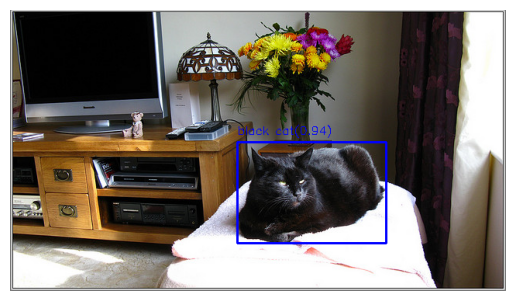

In [12]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
# 将PIL图像转换为OpenCV图像
opencv_image = np.array(image_pil)
opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)

# boxes_filt=boxes_filt.astype(np.int32)
# 边界框列表和对应的短语列表
# bboxes = [(50, 50, 150, 150), (200, 200, 300, 300)]  # 示例边界框
# phrases = ["对象1", "对象2"]  # 示例短语
# boxes_filt=[box.numpy() for box in boxes_filt]
# 在图像上绘制边界框和短语
for bbox, phrase in zip(boxes_filt, pred_phrases):
    bbox=[int(num) for num in bbox]
    # print(bbox)
    # 绘制边界框
    cv2.rectangle(opencv_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    
    # 绘制文本
    cv2.putText(opencv_image, phrase, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# 将图像从BGR转换回RGB，以便在Jupyter Notebook中正确显示
opencv_image_rgb = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)

# 使用matplotlib显示图像
plt.imshow(opencv_image_rgb)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [13]:
import re
# 获取图像文件名并创建对应的文件夹
def save_obj_image(full_image_path, boxes_filt, pred_phrases, topk=5):
    mid_res_dir = '/root/autodl-tmp/mmcot_test/mid_res_test'
    image_dir, image_name = os.path.split(full_image_path)
    image_name_without_ext = os.path.splitext(image_name)[0]
    folder_path = os.path.join(mid_res_dir, image_name_without_ext)

    # 如果文件夹不存在，则创建
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    idx=0
    # 遍历边界框和短语
    for idx, (bbox, phrase) in enumerate(zip(boxes_filt, pred_phrases)):
        if idx >= topk:
            break
        # phrase=re.sub(r'\([^)]*\)', '', phrase)
        bbox=[int(num) for num in bbox]
        # 裁剪图像
        cropped_image = image_pil.crop(bbox)

        # 构建保存路径并保存图像
        # 在文件名中加入索引（id）以确保唯一性
        save_path = os.path.join(folder_path, f"{phrase}_{idx}.jpg")
        cropped_image.save(save_path)
        
save_obj_image(full_image_path, boxes_filt, pred_phrases, topk=1)

### q2

In [14]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
predict_model = OtterForConditionalGeneration.from_pretrained("/root/autodl-tmp/cacheFile/.cache/huggingface/hub/OTTER-Image-LLaMA7B-LA-InContext", device_map="auto")
predict_model.text_tokenizer.padding_side = "left"
tokenizer = predict_model.text_tokenizer
image_processor = transformers.CLIPImageProcessor()
predict_model.eval()

The current model version is configured for Otter-Image with max_num_frames set to None.
Parameter: lang_encoder.model.embed_tokens.weight, Size: 131.088384 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn_gate, Size: 0.000001 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.ff_gate, Size: 0.000001 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.norm.weight, Size: 0.004096 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.norm.bias, Size: 0.004096 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.to_q.weight, Size: 2.097152 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.to_kv.weight, Size: 1.048576 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.to_out.weight, Size: 2.097152 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.feed_forward.0.weight, Size: 0.004096 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.feed_forward.

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

OtterForConditionalGeneration(
  (lang_encoder): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(32004, 4096, padding_idx=0)
      (layers): ModuleList(
        (0): OtterLayer(
          (decoder_layer): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLU()
            )

In [16]:
def get_predict(urls, prompt):
    image_list = []
    for url in urls:
        image_list.append(get_image(url))
    return get_response_test(image_list, prompt, model=predict_model, image_processor=image_processor)

In [17]:
urls = [
            "/root/autodl-tmp/mmcot_test/mid_res_test/n157115/black cat(0.94)_0.jpg",
            "/root/autodl-tmp/mmcot_test/n157115.jpg",
        ]

prompts_input = ["User:What is directly behind <image> in the <image>? GPT:<answer>"]

q2_result = get_predict(urls, prompts_input[0])


In [18]:
q2_result

'The flowers are directly behind the cat.'

In [19]:
boxes_filt, pred_phrases, image_pil, image = get_det(det_model, full_image_path, "flowers")

In [39]:
save_obj_image(full_image_path, boxes_filt, pred_phrases, topk=1)

### q3

In [51]:
urls = [
            "/root/autodl-tmp/mmcot_test/n157115.jpg",
            "/root/autodl-tmp/mmcot_test/mid_res_test/n157115/flowers(0.40)_0.jpg",
        ]

prompts_input = ["User:<image>What is on the left of <image>? GPT:<answer>"]

q2_result = get_predict(urls, prompts_input[0])
print(q2_result)

The vase is placed on the side of the glass table.


In [52]:
boxes_filt, pred_phrases, image_pil, image = get_det(det_model, full_image_path, "table")
save_obj_image(full_image_path, boxes_filt, pred_phrases, topk=1)

### q4

In [54]:
urls = [
            "/root/autodl-tmp/mmcot_test/n157115.jpg",
            "/root/autodl-tmp/mmcot_test/mid_res_test/n157115/table(0.43)_0.jpg",
        ]

# 难点：如何构建prompt
prompts_input = ["User:<image>What is the biggest item on top of <image>? GPT:<answer>"]

q2_result = get_predict(urls, prompts_input[0])
print(q2_result)

The TV is the largest item on the top of the pile.
